# Data management

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gzip
import json
import pandas as pd
from tqdm import tqdm
from io import StringIO

In [ ]:
## Paths
dataset_path = '/content/drive/MyDrive/ColabNotebooks/KeepCodingIA/NLP/Project/Data/Video_Games_5.json.gz'
unzipped_dataset_path = '/content/drive/MyDrive/ColabNotebooks/KeepCodingIA/NLP/Project/Data/Video_Games_5.json'

In [ ]:
# Takes dataset_path unzipps it and saves it in unzipped_dataset_path
!gunzip -c "{dataset_path}" > "{unzipped_dataset_path}"

# Verifying it it was unzipped correctly
!ls -l "{unzipped_dataset_path}"

-rw------- 1 root root 466833438 Dec  8 12:05 /content/drive/MyDrive/ColabNotebooks/KeepCodingIA/NLP/Project/Data/Video_Games_5.json


In the end, I decided that the subset will contain 500 samples in total, since I had to work on a subset during preprocessing and the data would have been biased, so I directly took 500 samples from the start. Preprocessing 500 samples takes about 9 minutes.

In [ ]:
'''
Dataset unzipped and stored reading, filtering reviews into positive and negative categories
and creating a balanced DF with an equal number of each
'''

# Set up variables
positive_reviews = []
negative_reviews = []
max_reviews = 250  # Maximum number of reviews per category

# Open file and estimate total lines (optional, for more accurate progress tracking)
with open(unzipped_dataset_path, 'r') as dataFile:
    total_lines = sum(1 for _ in dataFile)  # Counts the number of lines in the file

# Read and process the file with a progress bar
with open(unzipped_dataset_path, 'r') as dataFile:
    with tqdm(total=total_lines, desc="Processing Reviews", unit="line") as pbar:
        while len(positive_reviews) < max_reviews or len(negative_reviews) < max_reviews:
            line = dataFile.readline()
            if not line:  # If reached the end, stop
                break
            register = pd.read_json(StringIO(line), typ='series')  # Convert line to pandas Series
            overall = register['overall']  # We'll use the overall rating to classify
            # Classification by overall rating
            if overall >= 4 and len(positive_reviews) < max_reviews:
                positive_reviews.append(register)
            elif overall <= 3 and len(negative_reviews) < max_reviews:
                negative_reviews.append(register)
            pbar.update(1)  # Update the progress bar with one processed line

# Convert the lists of positive and negative reviews into pandas DF
df_positive = pd.DataFrame(positive_reviews)
df_negative = pd.DataFrame(negative_reviews)

# Merge both DF into one, reset index to keep it clean
final_df = pd.concat([df_positive, df_negative]).reset_index(drop=True)


Processing Reviews:   0%|          | 0/497577 [00:00<?, ?line/s]<ipython-input-5-e08577fe06bd>:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  register = pd.read_json(StringIO(line), typ='series')  # Convert line to pandas Series
<ipython-input-5-e08577fe06bd>:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  register = pd.read_json(StringIO(line), typ='series')  # Convert line to pandas Series
<ipython-input-5-e08577fe06bd>:22: FutureWarning: The behavior of 'to_datetime' with '

In [ ]:
final_df_path = '/content/drive/MyDrive/ColabNotebooks/KeepCodingIA/NLP/Project/Data/final_df.csv'
final_df.to_csv(final_df_path, index=False)

In [ ]:
final_df.describe()

,overall,unixReviewTime
count,500.000000,5.000000e+02
mean,3.482000,1.328518e+09
std,1.481237,1.429449e+08
min,1.000000,9.449568e+08
25%,2.000000,1.305331e+09
50%,3.500000,1.379506e+09
75%,5.000000,1.419833e+09
max,5.000000,1.514851e+09


In [ ]:
len(positive_reviews)

250

In [ ]:
positive_reviews[0]

,0
overall,5.0
verified,True
reviewTime,"10 17, 2015"
reviewerID,A1HP7NVNPFMA4N
asin,0700026657
reviewerName,Ambrosia075
reviewText,"This game is a bit hard to get the hang of, bu..."
summary,but when you do it's great.
unixReviewTime,1445040000


In [ ]:
len(negative_reviews)

250

In [ ]:
negative_reviews[0]

,0
overall,3.0
verified,True
reviewTime,"02 23, 2015"
reviewerID,A1YJWEXHQBWK2B
asin,0700026657
reviewerName,Vincent G. Mezera
reviewText,ok game.
summary,Three Stars
unixReviewTime,1424649600


# Data exploration

In [ ]:
df_path = '/content/drive/MyDrive/ColabNotebooks/KeepCodingIA/NLP/Project/Data/final_df.csv'
data = pd.read_csv(df_path)

### Reviews distribution by rate

<Axes: xlabel='overall'>

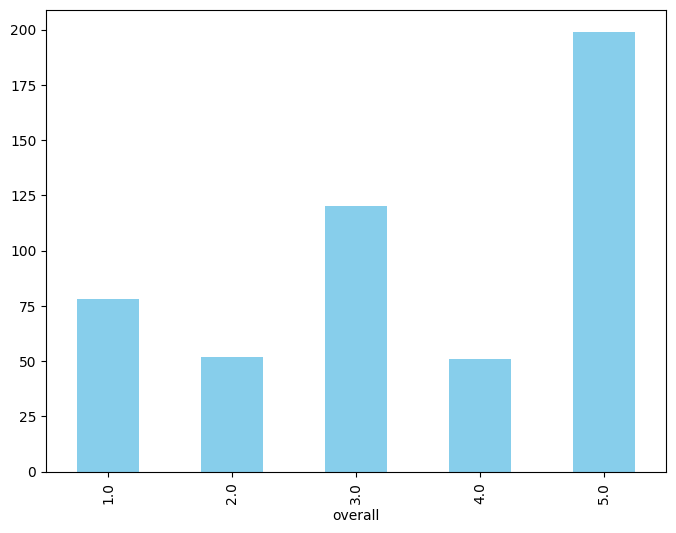

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
data['overall'].value_counts().sort_index().plot(kind='bar', color='skyblue')

Con el gráfico observamos que la mayoría de las reviews son de 3 y 5 estrellas.

#### Reviews distribution by rate binary

In [ ]:
def binary_rate(rate):
    if int(rate['overall']) >= 4:
        return 1
    else:
        return 0

In [ ]:
aux_df = data.copy()
aux_df['overall_binary'] = aux_df.apply(lambda rate: binary_rate(rate), axis=1)

<Axes: xlabel='overall_binary'>

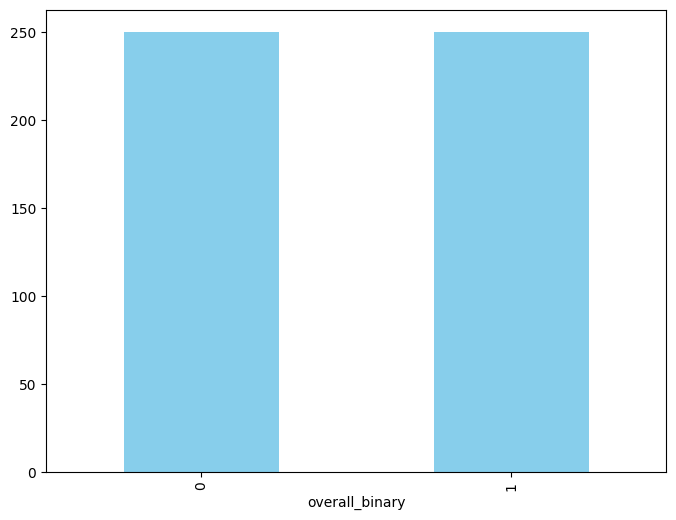

In [ ]:
plt.figure(figsize=(8, 6))
aux_df['overall_binary'].value_counts().sort_index().plot(kind='bar', color='skyblue')

Obviously, there is the same number of positive as negative reviews, since we created the dataset specifying that the data should be balanced.

### Word Cloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
def plot_word_cloud(review_text):
    # Convert the Series of lists into a single list of words
    all_words = [word for sublist in review_text for word in sublist]
    # Join the words into a single string
    wordcloud = WordCloud(max_font_size=50, max_words=80, background_color="black").generate(' '.join(all_words))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
review_text = data['reviewText'].astype(str)
review_text = review_text.str.lower()
review_text = review_text.str.split()

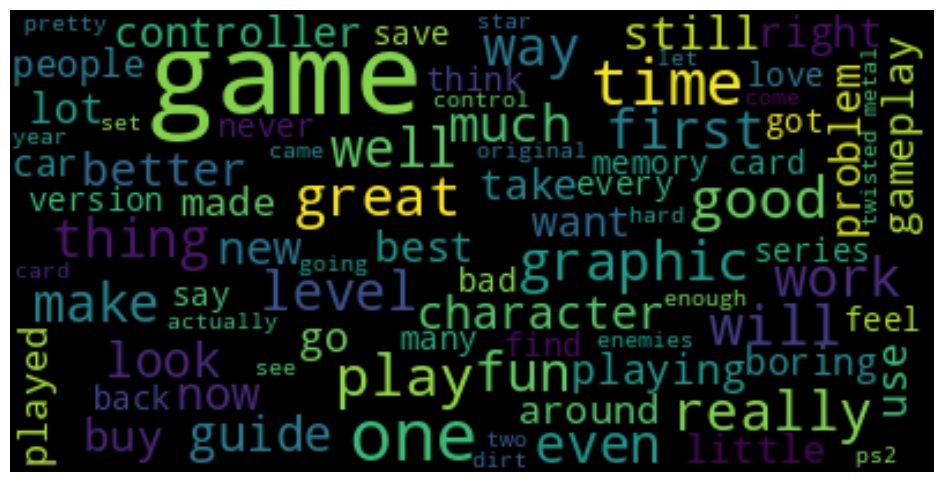

In [ ]:
plot_word_cloud(review_text)

With the word cloud, we can see that "game" appears to be the most frequent word.

In [ ]:
review_text[1]

['i',
 'played',
 'it',
 'a',
 'while',
 'but',
 'it',
 'was',
 'alright.',
 'the',
 'steam',
 'was',
 'a',
 'bit',
 'of',
 'trouble.',
 'the',
 'more',
 'they',
 'move',
 'these',
 'game',
 'to',
 'steam',
 'the',
 'more',
 'of',
 'a',
 'hard',
 'time',
 'i',
 'have',
 'activating',
 'and',
 'playing',
 'a',
 'game.',
 'but',
 'in',
 'spite',
 'of',
 'that',
 'it',
 'was',
 'fun,',
 'i',
 'liked',
 'it.',
 'now',
 'i',
 'am',
 'looking',
 'forward',
 'to',
 'anno',
 '2205',
 'i',
 'really',
 'want',
 'to',
 'play',
 'my',
 'way',
 'to',
 'the',
 'moon.']

### Most frequent words

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

In [ ]:
# We flatten the list so we get ONE list with all the words inside, intead of lists inside the main list
all_words = [word for sublist in review_text for word in sublist]
word_freq = Counter(all_words)

In [ ]:
word_freq_most_common = word_freq.most_common(10)

In [ ]:
word_freq_most_common

[('the', 2872),
 ('and', 1359),
 ('to', 1342),
 ('a', 1261),
 ('i', 1038),
 ('of', 969),
 ('is', 958),
 ('it', 893),
 ('you', 786),
 ('this', 733)]

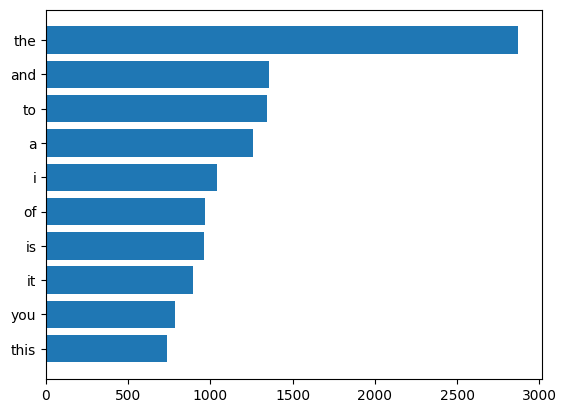

In [ ]:
words = [w[0] for w in word_freq_most_common]
freqs = [w[1] for w in word_freq_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))
plt.barh(words, freqs)
plt.show()

We observe that the 9 most used words, with "game" being the exception, are stop-words. Therefore, removing stop-words, aside from being necessary, will significantly alter this graph.

###N-grams


In [ ]:
from nltk import ngrams
from nltk.probability import FreqDist

In [ ]:
bigrams_ = ngrams(all_words, 2)
trigrams_ = ngrams(all_words, 3)
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

In [ ]:
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common] # takes the biagram combinations and frequency of each, turns it into strings
bgs_f_ = [bg[1] for bg in bg_freq_most_common] # takes the most common biagrams, returns strings

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common] # same but for tregram
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [ ]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

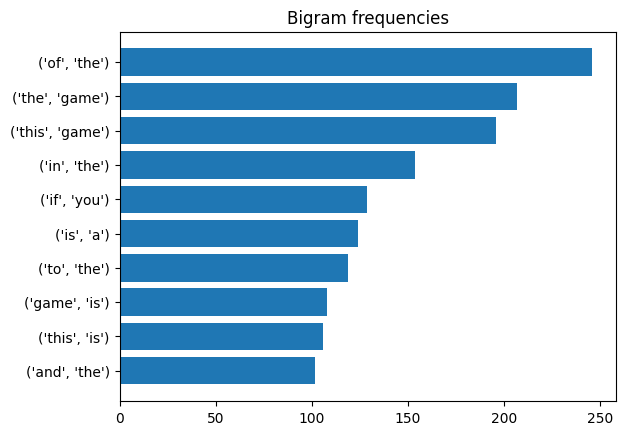

In [ ]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

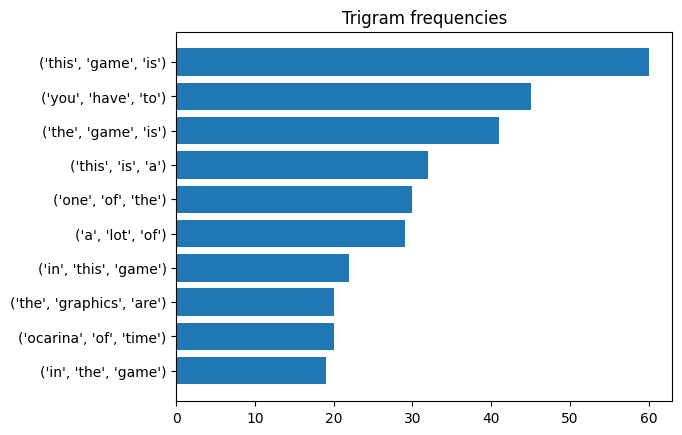

In [ ]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

Once again, we observe how a large part of the most frequent vocabulary consists of stop words.